In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [32]:
def get_dist(data, bins='auto'):
    hist, edges = np.histogram(data['Return'], bins=bins)
    # Calculate the probabilities of each return value
    prob = hist / len(data['Return'])

    # Remove any probabilities and corresponding returns that are equal to zero
    pos_prob = prob[edges[:-1] > 0]
    pos_ret = edges[:-1][edges[:-1] > 0]
    neg_prob = prob[edges[:-1] < 0]
    neg_ret = edges[:-1][edges[:-1] < 0]

    pos_mask = pos_prob > 0
    pos_prob = pos_prob[pos_mask]
    pos_ret = pos_ret[pos_mask]

    neg_mask = neg_prob > 0
    neg_prob = neg_prob[neg_mask]
    neg_ret = neg_ret[neg_mask]

    return pos_ret, pos_prob, neg_ret, neg_prob

def OLS_fit(x, y, R2_only=True):
    model = sm.OLS(y, sm.add_constant(x))
    results = model.fit()
    R2 = results.rsquared
    if R2_only:
        return R2
    beta = results.params[1]
    alpha = results.params[0]
    return beta, alpha, R2

def get_boundary_value(ret_data):
    def sum_R2(ret, prob, pivot, pos):
        if pos:
            power_x = ret[ret > pivot]
            power_y = prob[ret > pivot]
            power_R2 = OLS_fit(np.log(power_x), np.log(power_y))
            # exp_x = ret[ret < pivot]
            # exp_y = prob[ret < pivot]
            # exp_R2 = OLS_fit(exp_x, np.log(exp_y))
        else:
            power_x = ret[ret < pivot]
            power_y = prob[ret < pivot]
            power_R2 = OLS_fit(np.log(-power_x), np.log(power_y))
            # exp_x = ret[ret > pivot]
            # exp_y = prob[ret > pivot]
            # exp_R2 = OLS_fit(-exp_x, np.log(exp_y))
            
        return power_R2  
        # return exp_R2  
        # return power_R2 + exp_R2

    pos_ret, pos_prob, neg_ret, neg_prob = get_dist(ret_data, bins='auto')
    # print(np.isnan(pos_ret).any())
    # print(np.isnan(neg_ret).any())

    pos_start, pos_end = pos_ret[1], pos_ret[-1] #pos_ret[10], pos_ret[-1]
    neg_start, neg_end = neg_ret[1], neg_ret[-1]  #neg_ret[1], neg_ret[-10]
    # print(neg_start)
    # print(neg_end)
    # print(pos_ret)
    # print(neg_ret)
    tick = 5e-5
    pos_R2, neg_R2 = [], []
    null_set = {np.inf, -np.inf, np.nan}
    for pos_pivot in np.arange(pos_start, pos_end, tick):
        tmp = sum_R2(pos_ret, pos_prob, pos_pivot, True)
        if tmp not in null_set and tmp > 0:
            pos_R2.append([pos_pivot, tmp])
    for neg_pivot in np.arange(neg_start, neg_end, tick):
        n_tmp = sum_R2(neg_ret, neg_prob, neg_pivot, False)
        if n_tmp not in null_set and n_tmp > 0:
            neg_R2.append([neg_pivot, n_tmp])
        # break
    
    return pos_R2, neg_R2

In [33]:
filename = '../exchange_data/BTC_1d_return.csv'
data = pd.read_csv(filename)

a, b = get_boundary_value(data)

/home/ruixuan/yes/envs/NLP/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [34]:
#if not np.isnan(x[1])
xp, yp = list(zip(*[x for x in a]))
xn, yn = list(zip(*[x for x in b]))

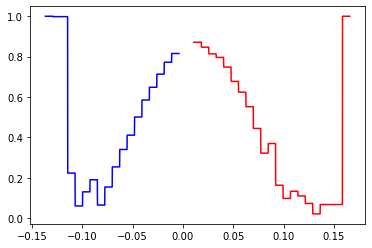

In [35]:
plt.plot(xp, yp, color='r')
plt.plot(xn, yn, color='b')
# plt.plot([x[1] for x in a], [x[1] for x in a], color='r')
# plt.plot([x[1] for x in a], [x[1] for x in b], color='b')

In [36]:
for pivot, r in a:
    if r > 0.8:
        print(pivot)
        break
for pivot, r in b:
    if r > 0.8:
        print(pivot)
        break

0.010858309545423939
-0.1366941563769854
